In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score 
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

/Users/alexkirnas/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sub_path = "../train_pred/"
all_files = [name for name in os.listdir(sub_path)]

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
0,dfd5f913,0.002231,0.002478,0.006814,0.015393,0.001188
1,e25388fd,0.000014,0.000275,0.000049,0.000279,0.000003
2,58b2aaa0,0.929025,0.723265,0.793231,0.680132,0.971094
3,4cfc3a18,0.006041,0.007178,0.003818,0.033491,0.002326
4,271f93f4,0.001682,0.000876,0.000373,0.001129,0.000173


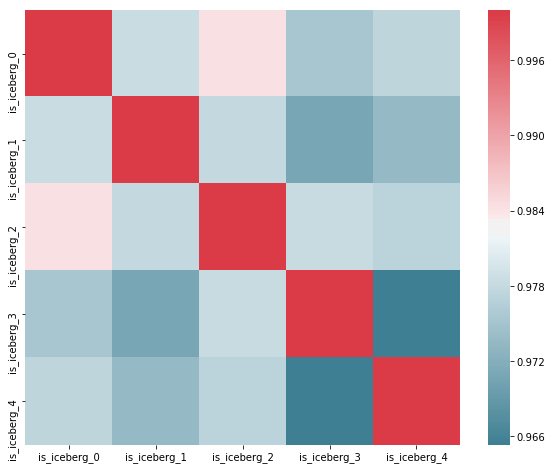

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 8))
corr = concat_sub.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
corr

In [4]:
train = pd.read_json("../input/train.json")
test = pd.read_json("../input/test.json")

In [5]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [6]:
train.drop(['band_1', 'band_2'], axis=1, inplace=True)

In [7]:
train = pd.merge(train, concat_sub, on='id')

In [8]:
train.head()

,id,inc_angle,is_iceberg,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
0,dfd5f913,43.9239,0,0.002231,0.002478,0.006814,0.015393,0.001188
1,e25388fd,38.1562,0,0.000014,0.000275,0.000049,0.000279,0.000003
2,58b2aaa0,45.2859,1,0.929025,0.723265,0.793231,0.680132,0.971094
3,4cfc3a18,43.8306,0,0.006041,0.007178,0.003818,0.033491,0.002326
4,271f93f4,35.6256,0,0.001682,0.000876,0.000373,0.001129,0.000173


In [9]:
y = train['is_iceberg'].as_matrix()

In [10]:
train.drop(['id', 'is_iceberg', 'inc_angle'], axis=1, inplace=True)

In [11]:
x = train.as_matrix()

In [12]:
x

array([[  2.23111594e-03,   2.47819698e-03,   6.81425072e-03,
          1.53928008e-02,   1.18804001e-03],
       [  1.38275836e-05,   2.75269645e-04,   4.86871832e-05,
          2.79270578e-04,   2.64864093e-06],
       [  9.29025114e-01,   7.23264873e-01,   7.93231070e-01,
          6.80131912e-01,   9.71093535e-01],
       ..., 
       [  5.30921035e-02,   4.99295853e-02,   3.81115675e-02,
          3.75144444e-02,   9.33770090e-02],
       [  2.54477412e-02,   1.07758008e-02,   3.66303325e-03,
          7.00016469e-02,   5.29507408e-03],
       [  8.06853026e-02,   2.95005888e-02,   6.34879172e-02,
          1.99470654e-01,   1.05904508e-02]])

In [13]:
def logloss_softmax(y_true, y_pred, eps=1e-15):
    proba = y_pred[np.arange(len(y_pred)), y_true]
    proba = np.clip(proba, eps, 1 - eps)
    return -np.mean(np.log(proba))

In [14]:
kfold_data = []
kf = KFold(n_splits=5, shuffle=True, random_state=0x42)

for train_indices, val_indices in kf.split(y):
    X_train_cv = x[train_indices]
    y_train_cv = y[train_indices]

    X_val = x[val_indices]
    y_val = y[val_indices]

    kfold_data.append((X_train_cv, y_train_cv, X_val, y_val))

In [101]:
tr_acc = []
tr_loss = []

acc = []
loss = []

for x_train, y_train, x_val, y_val in kfold_data:
    gbm = xgb.XGBClassifier(n_estimators=52,
                            max_depth=3, 
                            subsample=0.9,
                            colsample_bytree=0.9,
                            learning_rate=0.1,
                            reg_lambda=0.)
    gbm.fit(x_train, y_train)

    y_pred_val = gbm.predict(x_val)
    y_pred_train = gbm.predict(x_train)

    train_acc = accuracy_score(y_train, y_pred_train, normalize=True)
    val_acc = accuracy_score(y_val, y_pred_val, normalize=True)

    train_loss = logloss_softmax(y_train, gbm.predict_proba(x_train))
    val_loss = logloss_softmax(y_val, gbm.predict_proba(x_val))

    print("Train accuracy: %.5f" % train_acc)
    print("Validation accuracy: %.5f" % val_acc)
    print('------------------------------\n\n')
    tr_acc.append(train_acc)
    acc.append(val_acc)

    tr_loss.append(train_loss)
    loss.append(val_loss)
    
print('Avg val_acc:', np.mean(acc))
print('Avg val_loss:', np.mean(loss))

print('Avg train_acc:', np.mean(tr_acc))
print('Avg train_loss:', np.mean(tr_loss))

Train accuracy: 0.98051
Validation accuracy: 0.96262
------------------------------


Train accuracy: 0.98285
Validation accuracy: 0.94704
------------------------------


Train accuracy: 0.98051
Validation accuracy: 0.97196
------------------------------


Train accuracy: 0.97973
Validation accuracy: 0.97508
------------------------------


Train accuracy: 0.98053
Validation accuracy: 0.94688
------------------------------


Avg val_acc: 0.960714563863
Avg val_loss: 0.105897
Avg train_acc: 0.980829223758
Avg train_loss: 0.0560774


In [102]:
scores_base = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_base_on_this_split = cross_val_score(
                                             estimator=xgb.XGBClassifier(
                                                 n_estimators=52,
                                                 max_depth=3, 
                                                 subsample=0.9,
                                                 colsample_bytree=0.8,
                                                 learning_rate=0.1,
                                                 reg_lambda=0.),
                                             X=x, y=y,
                                             cv=fold, scoring='neg_log_loss')
    scores_base = np.append(scores_base, scores_base_on_this_split)

100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


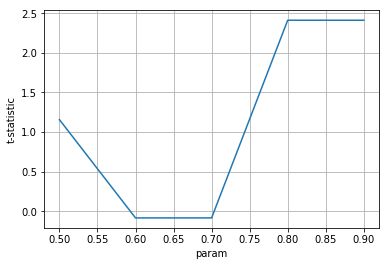

In [99]:
from scipy.stats import ttest_rel
from tqdm import tqdm

t_stats = []
n_trees = []
for j in tqdm(np.arange(0.5, 1.01, 0.1)):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
                                      estimator=xgb.XGBClassifier(
                                          n_estimators=52,
                                          max_depth=3,
                                          subsample=0.9,
                                          colsample_bytree=0.9,
                                          learning_rate=0.1,
                                          reg_lambda=0.),
                                      X=x, y=y,
                                      cv=fold, scoring='neg_log_loss')
        current_score = np.append(current_score,
                                  scores_on_this_split)
    t_stat, p_value = ttest_rel(current_score, scores_base)
    t_stats.append(t_stat)
    n_trees.append(j)
plt.plot(n_trees, t_stats)
plt.grid()
plt.xlabel('param')
plt.ylabel('t-statistic')

In [ ]:
from sklearn.neural_network import MLPClassifier

In [54]:
tr_acc = []
tr_loss = []

acc = []
loss = []

for x_train, y_train, x_val, y_val in kfold_data:
    
    gbm = MLPClassifier(
            hidden_layer_sizes=(15, 15, 5), activation="tanh",
            solver='lbfgs', alpha=0.,
            batch_size=256,
            learning_rate_init=0.001, max_iter=200,
            shuffle=False, tol=1e-3,verbose=False,
           early_stopping=True)

    gbm.fit(x_train, y_train)

    y_pred_val = gbm.predict(x_val)
    y_pred_train = gbm.predict(x_train)

    train_acc = accuracy_score(y_train, y_pred_train, normalize=True)
    val_acc = accuracy_score(y_val, y_pred_val, normalize=True)

    train_loss = logloss_softmax(y_train, gbm.predict_proba(x_train))
    val_loss = logloss_softmax(y_val, gbm.predict_proba(x_val))

    print("Train accuracy: %.5f" % train_acc)
    print("Validation accuracy: %.5f" % val_acc)
    print('------------------------------\n\n')
    tr_acc.append(train_acc)
    acc.append(val_acc)

    tr_loss.append(train_loss)
    loss.append(val_loss)
    
print('Avg val_acc:', np.mean(acc))
print('Avg val_loss:', np.mean(loss))

print('Avg train_acc:', np.mean(tr_acc))
print('Avg train_loss:', np.mean(tr_loss))

Train accuracy: 0.96259
Validation accuracy: 0.96262
------------------------------


Train accuracy: 0.98831
Validation accuracy: 0.93769
------------------------------


Train accuracy: 0.97350
Validation accuracy: 0.96885
------------------------------


Train accuracy: 0.96103
Validation accuracy: 0.97819
------------------------------


Train accuracy: 0.96573
Validation accuracy: 0.95625
------------------------------


Avg val_acc: 0.960720404984
Avg val_loss: 0.244896880693
Avg train_acc: 0.970231374577
Avg train_loss: 0.0805545013688


In [ ]:
scores_base = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_base_on_this_split = cross_val_score(
                                             estimator=MLPClassifier(
                                                hidden_layer_sizes=(650, 45), activation="tanh",
                                                solver='lbfgs', alpha=0.01,
                                                batch_size=256,
                                                learning_rate_init=0.001, max_iter=200,
                                                shuffle=False, tol=1e-3,verbose=False,
                                                early_stopping=True),
                                             X=x, y=y,
                                             cv=fold, scoring='neg_log_loss')
    scores_base = np.append(scores_base, scores_base_on_this_split)

In [ ]:
from scipy.stats import ttest_rel
from tqdm import tqdm

t_stats = []
n_trees = []
for j in tqdm(np.arange(-5, 0, 1)):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
                                      estimator=MLPClassifier(
                                                 hidden_layer_sizes=(650, 45, 10), activation="tanh",
                                                 solver='lbfgs', alpha=0.01,
                                                 batch_size=256,
                                                 learning_rate_init=0.001, max_iter=200,
                                                 shuffle=False, tol=1e-3,verbose=False,
                                                 early_stopping=True),
                                      X=x, y=y,
                                      cv=fold, scoring='neg_log_loss')
        current_score = np.append(current_score,
                                  scores_on_this_split)
    t_stat, p_value = ttest_rel(current_score, scores_base)
    t_stats.append(t_stat)
    n_trees.append(j)
plt.plot(n_trees, t_stats)
plt.grid()
plt.xlabel('param')
plt.ylabel('t-statistic')

In [36]:
def logloss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


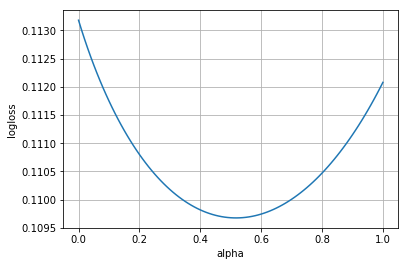

In [37]:
loss = []
value = []

for seed in tqdm(range(100)):
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(
                 x,
                 y,
                 random_state=seed,
                 train_size=0.8)

    gbm = xgb.XGBClassifier(n_estimators=52,
                        max_depth=3, 
                        subsample=0.8,
                        colsample_bytree=0.75,
                        learning_rate=0.1,
                        reg_lambda=0.1)
    gbm.fit(X_train_cv, y_train_cv)

    mlp = MLPClassifier(
            hidden_layer_sizes=(650, 45), activation="tanh",
            solver='lbfgs', alpha=0.,
            batch_size=128,
            learning_rate_init=0.001, max_iter=200,
            shuffle=False, tol=1e-3,verbose=False,
           early_stopping=True)

    mlp.fit(X_train_cv, y_train_cv)

    y_gbm = gbm.predict_proba(X_valid)[:, 1]
    y_mlp = mlp.predict_proba(X_valid)[:, 1]

    curr_loss = []
    curr_value = []

    for alpha in np.arange(0.0, 1.01, 0.01):
        curr_value.append(alpha)
        curr_loss.append(logloss(y_valid, alpha * y_gbm + (1 - alpha) * y_mlp))
    
    loss.append(curr_loss)
    value.append(curr_value)
    
plt.plot(value[-1], np.mean(loss, axis=0))
plt.grid()
plt.xlabel('alpha')
plt.ylabel('logloss')

In [38]:
idx = np.argmin(np.mean(loss, axis=0))
np.min(np.mean(loss, axis=0)), value[-1][idx]

(0.10967618654901956, 0.52000000000000002)

100%|██████████| 50/50 [00:12<00:00,  4.47it/s]


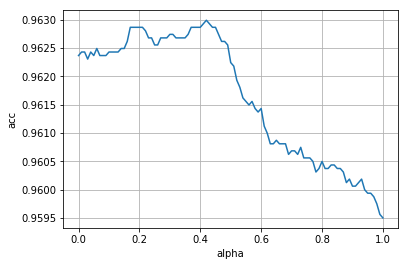

In [34]:
acc = []
value = []

for seed in tqdm(range(50)):
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(
                 x,
                 y,
                 random_state=seed,
                 train_size=0.8)

    gbm = xgb.XGBClassifier(n_estimators=52,
                        max_depth=3, 
                        subsample=0.8,
                        colsample_bytree=0.75,
                        learning_rate=0.1,
                        reg_lambda=0.1)
    gbm.fit(X_train_cv, y_train_cv)


    mlp = MLPClassifier(
            hidden_layer_sizes=(650, 45), activation="tanh",
            solver='lbfgs', alpha=0.,
            batch_size=128,
            learning_rate_init=0.001, max_iter=200,
            shuffle=False, tol=1e-3,verbose=False,
           early_stopping=True)

    mlp.fit(X_train_cv, y_train_cv)

    y_gbm = gbm.predict_proba(X_valid)[:, 1]
    y_mlp = mlp.predict_proba(X_valid)[:, 1]

    curr_acc = []
    curr_value = []

    for alpha in np.arange(0.0, 1.01, 0.01):
        curr_value.append(alpha)
        curr_acc.append(accuracy_score(y_valid, (alpha * y_gbm + (1 - alpha) * y_mlp) > 0.5, normalize=True))
    
    acc.append(curr_acc)
    value.append(curr_value)
    
plt.plot(value[-1], np.mean(acc, axis=0))
plt.grid()
plt.xlabel('alpha')
plt.ylabel('acc')

In [39]:
idx = np.argmax(np.mean(acc, axis=0))
np.max(np.mean(acc, axis=0)), value[-1][idx]

(0.96299065420560803, 0.41999999999999998)

In [40]:
gbm = xgb.XGBClassifier(n_estimators=52,
                        max_depth=3, 
                        subsample=1,
                        colsample_bytree=1,
                        learning_rate=0.1,
                        reg_lambda=0.)
gbm.fit(x, y)


mlp = MLPClassifier(
        hidden_layer_sizes=(650, 45), activation="tanh",
        solver='lbfgs', alpha=0.,
        batch_size=256,
        learning_rate_init=0.001, max_iter=200,
        shuffle=False, tol=1e-3,verbose=False,
        early_stopping=True)

mlp.fit(x, y)

MLPClassifier(activation='tanh', alpha=0.0, batch_size=256, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(650, 45), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=False, solver='lbfgs', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [41]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [42]:
sub_path = "../test_pred/"
all_files = [name for name in os.listdir(sub_path)]

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
0,5941774d,2.219321e-02,5.640716e-03,8.015390e-03,1.914136e-02,1.287736e-01
1,4023181e,2.963234e-01,9.442012e-01,4.307120e-01,1.000000e+00,1.434696e-01
2,b20200e4,1.202049e-17,4.619928e-17,2.254251e-20,8.278883e-08,2.877008e-38
3,e7f018bb,9.999999e-01,9.999901e-01,9.999712e-01,1.000000e+00,9.999992e-01
4,4371c8c3,9.823971e-01,7.043053e-03,9.999754e-01,9.999492e-01,9.876493e-01


In [43]:
test = pd.merge(test, concat_sub, on='id')

In [44]:
test.drop(['id', 'inc_angle'], axis=1, inplace=True)

In [45]:
test.drop(['band_1', 'band_2'], axis=1, inplace=True)

In [46]:
test.head()

,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
0,2.219321e-02,5.640716e-03,8.015390e-03,1.914136e-02,1.287736e-01
1,2.963234e-01,9.442012e-01,4.307120e-01,1.000000e+00,1.434696e-01
2,1.202049e-17,4.619928e-17,2.254251e-20,8.278883e-08,2.877008e-38
3,9.999999e-01,9.999901e-01,9.999712e-01,1.000000e+00,9.999992e-01
4,9.823971e-01,7.043053e-03,9.999754e-01,9.999492e-01,9.876493e-01


In [47]:
x_test = test.as_matrix()

In [49]:
gbm_y = gbm.predict_proba(x_test)[:, 1]
mlp_y = mlp.predict_proba(x_test)[:, 1]

alpha = 0.42
y_test = alpha * gbm_y + (1 - alpha) * mlp_y

In [50]:
y_test

array([ 0.01262511,  0.5451028 ,  0.00563465, ...,  0.00568622,
        0.9915046 ,  0.28483054])

In [51]:
mlp_y

array([ 0.00999103,  0.62694719,  0.0074399 , ...,  0.00752881,
        0.98773266,  0.3114672 ])

In [52]:
gbm_y

array([ 0.01626266,  0.43207961,  0.00314167, ...,  0.00314167,
        0.99671352,  0.24804661], dtype=float32)

In [53]:
def prepare_submission_train(proba, path):
    test = pd.read_json("../input/test.json")
    proba = np.array(proba)

    submission = pd.DataFrame()
    submission['id'] = test['id']
    submission['is_iceberg'] = proba.reshape((-1, 1))
    submission.to_csv(path, float_format='%.15f', index=False)
    
prepare_submission_train(y_test, path='./stacked_models.csv')

In [103]:
sub_path = "../best_models/"
all_files = [name for name in os.listdir(sub_path)]

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1
0,5941774d,0.005783,1.914135e-02
1,4023181e,0.408724,4.307108e-01
2,b20200e4,0.003810,2.876965e-38
3,e7f018bb,0.992872,1.000000e+00
4,4371c8c3,0.324846,9.876491e-01


In [119]:
x = concat_sub['is_iceberg_0']
y = concat_sub['is_iceberg_1']
concat_sub['is_iceberg'] = np.where((x > 0.5) & (y > 0.5),
                                    np.maximum(x, y),
                                    np.where((x < 0.5) & (y < 0.5),
                                             np.minimum(x, y),
                                             x))

In [120]:
concat_sub

,id,is_iceberg_0,is_iceberg_1,is_iceberg
0,5941774d,0.005783,1.914135e-02,5.783030e-03
1,4023181e,0.408724,4.307108e-01,4.087241e-01
2,b20200e4,0.003810,2.876965e-38,2.876965e-38
3,e7f018bb,0.992872,1.000000e+00,1.000000e+00
4,4371c8c3,0.324846,9.876491e-01,3.248461e-01
5,a8d9b1fd,0.004062,7.951100e-07,7.951100e-07
6,29e7727e,0.008473,6.295451e-04,6.295451e-04
7,92a51ffb,0.992857,1.000000e+00,1.000000e+00
8,c769ac97,0.003801,3.258789e-09,3.258789e-09
9,aee0547d,0.003797,2.674118e-08,2.674118e-08


In [121]:
np.sum(concat_sub['is_iceberg'].as_matrix() - concat_sub['is_iceberg_1'].as_matrix()) / 8423

-0.074311394292661634

In [122]:
def prepare_submission_train(proba, path):
    test = pd.read_json("../input/test.json")
    proba = np.array(proba)

    submission = pd.DataFrame()
    submission['id'] = test['id']
    submission['is_iceberg'] = proba.reshape((-1, 1))
    submission.to_csv(path, float_format='%.15f', index=False)
    
prepare_submission_train(concat_sub['is_iceberg'].as_matrix(), path='./stacked_models_stacking.csv')